This notebook shows how to use the generic Q1+ dataset wrapper in [PytorchEO](https://github.com/earthpulse/pytorchEO) for [EOTDL](https://www.eotdl.com/) to train a model.

First, install the PytorchEO package if it is not already installed.

In [4]:
#!pip install pytorch-eo

The generic Q1+ dataset wrapper can be used to wrap any dataset that is available in EOTDL with Q1+ quality. The goal is to be able to train a model on any Q1+ dataset available in EOTDL with minimal changes to this template.


> At this moment, not all Q1+ datasets may work. If you find one that does not work, please open an issue and we will fix it.

In [47]:
from pytorch_eo.datasets import EOTDLDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# for this particular case, we only keep the RGB bands from the 13-band Sentinel-2 image and normalize them to [0,1]
def rgb_norm(x, **kwargs): return (x[...,(3,2,1)] / 4000).clip(0,1)
trans = A.Compose([
	A.Lambda(image=rgb_norm),
	ToTensorV2() 
])

ds = EOTDLDataset("EuroSAT-Q1-small", batch_size=25, force=False, verbose=True, train_trans=trans, val_trans=trans, test_trans=trans) 

ds.setup()

Dataset `EuroSAT-Q1-small v1` already exists at data/EuroSAT-Q1-small/v1. To force download, use force=True or -f in the CLI.


The `force` argument will downlaod the dataset even if it is already downloaded.

In [48]:
ds.df

,image,label,class
0,data/EuroSAT-Q1-small/v1/assets/Industrial_100...,6,PermanentCrop
1,data/EuroSAT-Q1-small/v1/assets/Industrial_10.tif,9,SeaLake
2,data/EuroSAT-Q1-small/v1/assets/Highway_1.tif,5,Pasture
3,data/EuroSAT-Q1-small/v1/assets/AnnualCrop_1.tif,7,Residential
4,data/EuroSAT-Q1-small/v1/assets/Pasture_1.tif,6,PermanentCrop
...,...,...,...
95,data/EuroSAT-Q1-small/v1/assets/River_100.tif,2,HerbaceousVegetation
96,data/EuroSAT-Q1-small/v1/assets/Highway_10.tif,8,River
97,data/EuroSAT-Q1-small/v1/assets/Pasture_1001.tif,9,SeaLake
98,data/EuroSAT-Q1-small/v1/assets/River_1006.tif,7,Residential


In [49]:
ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

The wrapper will use the STAC metadata to generate the appropriate `Dataset` object. In this example, it is a classification dataset with Sentinel 2 images and one label per image.

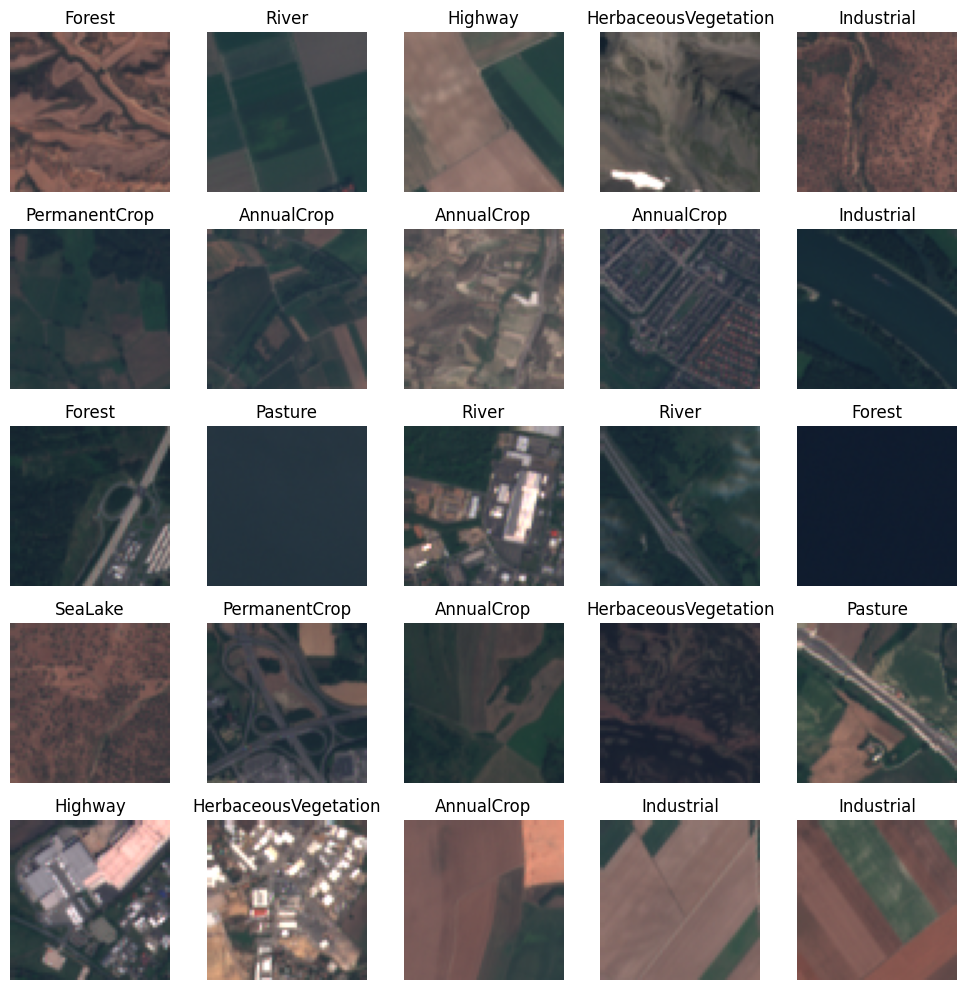

In [50]:
import matplotlib.pyplot as plt

# extract a batch of samples (you can also access val_dataloader or test_dataloader for the other splits)

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

Now we can train a model.

In [51]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification
import lightning as L

task = ImageClassification(num_classes=ds.num_classes)

trainer = L.Trainer(
    accelerator="cuda",
    devices=1,
    max_epochs=5,
)

trainer.fit(task, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juan/miniconda3/envs/eotdl/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | ResNet             | 11.2 M | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc     | MulticlassAccuracy | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Dataset `EuroSAT-Q1-small v1` already exists at data/EuroSAT-Q1-small/v1. To force download, use force=True or -f in the CLI.


/home/juan/miniconda3/envs/eotdl/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/juan/miniconda3/envs/eotdl/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
